# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções de Custo](#Funções-de-custo)

[Outras funções](#Outras-funções)

[Implementação](#Implementação)

[Testes](#Testes)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets.samples_generator import make_blobs, make_circles
from utils.samples_generator import make_spiral
from utils import plots

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Outras funções

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood_full(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        y_correct = np.argmax(y_oh, axis=1)
        dlog = neg_log_likelihood(y_oh, y_softmax, derivative=True)
        dsoftmax = softmax(y_pred, y_oh, derivative=True)
        y_softmax[range(y_softmax.shape[0]), y_correct] = dlog[range(dlog.shape[0]), y_correct]*dsoftmax[range(dsoftmax.shape[0]), y_correct]
        return y_softmax/y_softmax.shape[0]
    return neg_log_likelihood(y_oh, y_softmax)

# Implementação 

In [7]:
class NeuralNetwork():
    def __init__(self, layers_size, activations, cost_func, learning_rate=1e-3):
        self.layers_size = layers_size
        self.activations = activations
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self._activ_inp = []
        self._activ_out = []
        self.weights = [np.random.randn(out, inp) for inp, out in zip(self.layers_size[:-1], self.layers_size[1:])]
        self.biases = [np.random.randn(1, out) for out in self.layers_size[1:]]
            
    def fit(self, x, y, epochs=100, verbose=10):
        for epoch in range(epochs+1):
            y_pred = self.__feedforward(x)
            self.__backprop(y, y_pred)
            
            if epoch % verbose == 0:
                cost = self.cost_func(y, y_pred)
                print("epoch: {0:=4}/{1} cost: {2:.8f}".format(epoch, epochs, cost))
    
    def predict(self, x):
        return self.__feedforward(x)
    
    def __feedforward(self, x):
        self._activ_inp, self._activ_out = [], []
        self._activ_out.append(x)
        for w, b, activation in zip(self.weights, self.biases, self.activations):
            y = np.dot(self._activ_out[-1], w.T) + b
            self._activ_inp.append(y)
            self._activ_out.append(activation(y))
        return self._activ_out[-1]
    
    def __backprop(self, y, y_pred):
        self._activ_out.pop()
        
        last_delta = self.cost_func(y, y_pred, derivative=True)
        dweights, dbiases = [], []
        for inp, out, w, activation in zip(self._activ_inp[::-1], self._activ_out[::-1], self.weights[::-1], self.activations[::-1]):
            dactivation = activation(inp, derivative=True)*last_delta
            last_delta = np.dot(dactivation, w)
            dweights.append(np.dot(dactivation.T, out))
            dbiases.append(1.0*dactivation.sum(axis=0, keepdims=True))
        
        self.weights = [w - self.learning_rate*dw for w, dw in zip(self.weights, reversed(dweights))]
        self.biases  = [b - self.learning_rate*db for b, db in zip(self.biases, reversed(dbiases))]

# Testes da Implementação

## Exemplos do Notebook da Intuição

### Exemplo 1

In [8]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 2], activations=[sigmoid, sigmoid], cost_func=mse, learning_rate=0.5)

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]])
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

nn.weights = [w1, w2]
nn.biases = [b1, b2]

nn.fit(x, y, epochs=0, verbose=1)

for w in nn.weights:
    print(w)

epoch:    0/0 cost: 0.29837111
[[ 0.14978072  0.19956143]
 [ 0.24975114  0.29950229]]
[[ 0.35891648  0.40866619]
 [ 0.51130127  0.56137012]]


### Exemplo 2

In [9]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])

D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 3, 3, 3], activations=[relu, sigmoid, linear], cost_func=softmax_neg_log_likelihood_full, learning_rate=0.01)

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

nn.weights = [w1, w2, w3]
nn.biases = [b1, b2, b3]

nn.fit(x, y, epochs=300, verbose=30)

for w in nn.weights:
    print(w)

epoch:    0/300 cost: 1.16744561
epoch:   30/300 cost: 0.60797958
epoch:   60/300 cost: 0.36558760
epoch:   90/300 cost: 0.24943452
epoch:  120/300 cost: 0.18547915
epoch:  150/300 cost: 0.14614615
epoch:  180/300 cost: 0.11990516
epoch:  210/300 cost: 0.10131084
epoch:  240/300 cost: 0.08751844
epoch:  270/300 cost: 0.07691721
epoch:  300/300 cost: 0.06853445
[[ 0.10083595  0.2016719   0.30585165]
 [ 0.30086971  0.20173942  0.70608796]
 [ 0.40145052  0.30290104  0.91015363]]
[[ 0.20544723  0.30673159  0.50749567]
 [ 0.30994562  0.5123005   0.71366784]
 [ 0.61065514  0.41317913  0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Regressão

### Exemplo do Perceptron

In [10]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [11]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 1.0


epoch:    0/1000 cost: 5916.25239268
epoch:  100/1000 cost: 31.81691020
epoch:  200/1000 cost: 26.21463458
epoch:  300/1000 cost: 26.08594033
epoch:  400/1000 cost: 26.08298399
epoch:  500/1000 cost: 26.08291608
epoch:  600/1000 cost: 26.08291452
epoch:  700/1000 cost: 26.08291448
epoch:  800/1000 cost: 26.08291448
epoch:  900/1000 cost: 26.08291448
epoch: 1000/1000 cost: 26.08291448
[array([[ 33.60164744]])]
[array([[ 74.99636286]])]


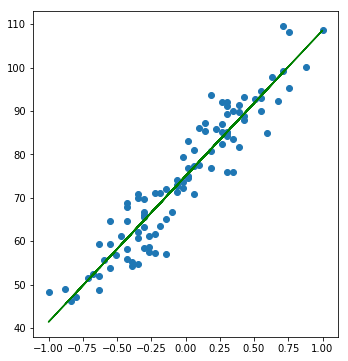

In [12]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 1], activations=[linear], cost_func=mse, learning_rate=1e-3)
nn.fit(x, y, epochs=1000, verbose=100)

print(nn.weights)
print(nn.biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Exercício de Regressão do Perceptron

In [13]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [14]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [ 1.  1.  1.]


In [15]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 1], activations=[linear], cost_func=mse, learning_rate=1e-2)
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.weights)
print(nn.biases)

epoch:    0/2000 cost: 27271.44867389
epoch:  200/2000 cost: 6.93720551
epoch:  400/2000 cost: 5.83436269
epoch:  600/2000 cost: 5.74892553
epoch:  800/2000 cost: 5.73921741
epoch: 1000/2000 cost: 5.73798955
epoch: 1200/2000 cost: 5.73783082
epoch: 1400/2000 cost: 5.73781022
epoch: 1600/2000 cost: 5.73780754
epoch: 1800/2000 cost: 5.73780720
epoch: 2000/2000 cost: 5.73780715
[array([[  8.72094419,  14.10519243,  26.26731969]])]
[array([[ 150.65173206]])]


### Regressão Quadrática

In [16]:
data = np.loadtxt('data/baseball_hit.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)
print(x.shape, y.shape)

(13, 2)
(13, 1) (13, 1)


In [17]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 54321.18090819
epoch: 1000/10000 cost: 16.35055479
epoch: 2000/10000 cost: 5.22735308
epoch: 3000/10000 cost: 2.17540472
epoch: 4000/10000 cost: 0.75263013
epoch: 5000/10000 cost: 0.14622621
epoch: 6000/10000 cost: 0.01927420
epoch: 7000/10000 cost: 0.01096065
epoch: 8000/10000 cost: 0.00719183
epoch: 9000/10000 cost: 0.00548001
epoch: 10000/10000 cost: 0.00466907


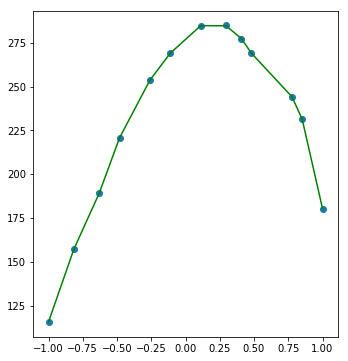

In [18]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 10, 10, 1], activations=[tanh, tanh, linear], cost_func=mse, learning_rate=1e-4)
nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [19]:
data = np.loadtxt('data/arvores.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)
print(x.shape, y.shape)

(11, 2)
(11, 1) (11, 1)


In [20]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 212.64350981
epoch: 1000/10000 cost: 0.17527696
epoch: 2000/10000 cost: 0.04834585
epoch: 3000/10000 cost: 0.01815471
epoch: 4000/10000 cost: 0.00953064
epoch: 5000/10000 cost: 0.00656152
epoch: 6000/10000 cost: 0.00525524
epoch: 7000/10000 cost: 0.00451410
epoch: 8000/10000 cost: 0.00401099
epoch: 9000/10000 cost: 0.00363544
epoch: 10000/10000 cost: 0.00334195


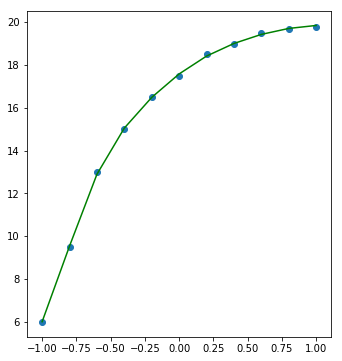

In [21]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 10, 10, 1], activations=[tanh, tanh, linear], cost_func=mse, learning_rate=1e-4)
nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [22]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 cost: 0.76869156
epoch: 1000/5000 cost: 0.04592042
epoch: 2000/5000 cost: 0.03112879
epoch: 3000/5000 cost: 0.02494117
epoch: 4000/5000 cost: 0.02135794
epoch: 5000/5000 cost: 0.01895720
[array([[ 7.27951188,  7.27951188]])] [array([[-11.00679882]])]
[[  1.65882589e-05]
 [  2.34928273e-02]
 [  2.34928273e-02]
 [  9.72137754e-01]]


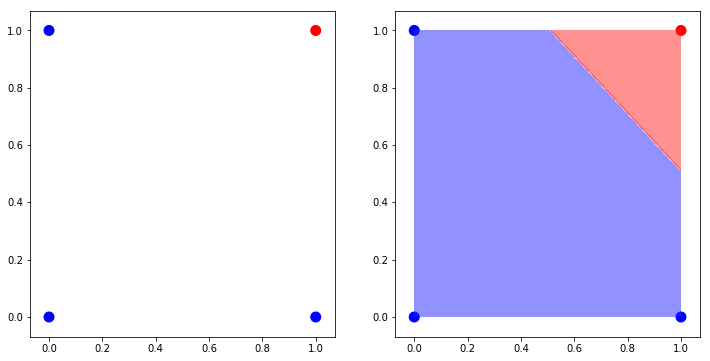

In [23]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 1], activations=[sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.fit(x, y, epochs=5000, verbose=1000)

print(nn.weights, nn.biases)
print(nn.predict(x))

plots.plot_data_and_predictions_3d_in_2d(x, y, nn, threshold=0.5, figsize=(12,6))

### Porta XOR

In [24]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 cost: 1.02923575
epoch: 1000/5000 cost: 0.06475889
epoch: 2000/5000 cost: 0.03306174
epoch: 3000/5000 cost: 0.02470535
epoch: 4000/5000 cost: 0.02048479
epoch: 5000/5000 cost: 0.01784377
[[ 0.01656416]
 [ 0.98313821]
 [ 0.98312639]
 [ 0.02042882]]


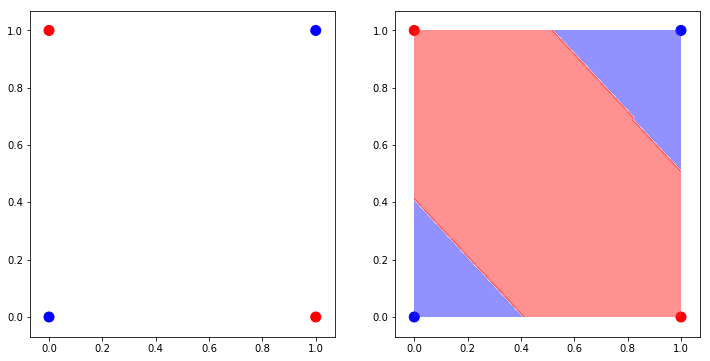

In [25]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 1], activations=[sigmoid, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1.0)

nn.fit(x, y, epochs=5000, verbose=1000)
print(nn.predict(x))

plots.plot_data_and_predictions_3d_in_2d(x, y, nn, threshold=0.5)

### 2 Clusters

In [26]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 cost: 1.09956408
epoch: 1000/5000 cost: 0.03059646
epoch: 2000/5000 cost: 0.02202804
epoch: 3000/5000 cost: 0.01792811
epoch: 4000/5000 cost: 0.01541208
epoch: 5000/5000 cost: 0.01367026


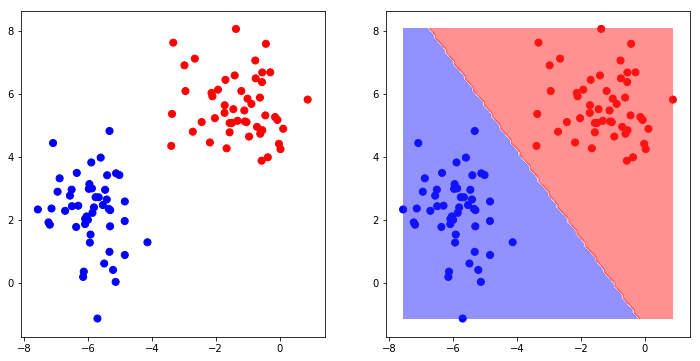

In [27]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 1], activations=[sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3)

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, nn, threshold=0.5, s=50)

### 4 Clusters

In [28]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/5000 cost: 2.27255984
epoch: 1000/5000 cost: 0.02818265
epoch: 2000/5000 cost: 0.01804742
epoch: 3000/5000 cost: 0.01394471
epoch: 4000/5000 cost: 0.01164980
epoch: 5000/5000 cost: 0.01014071


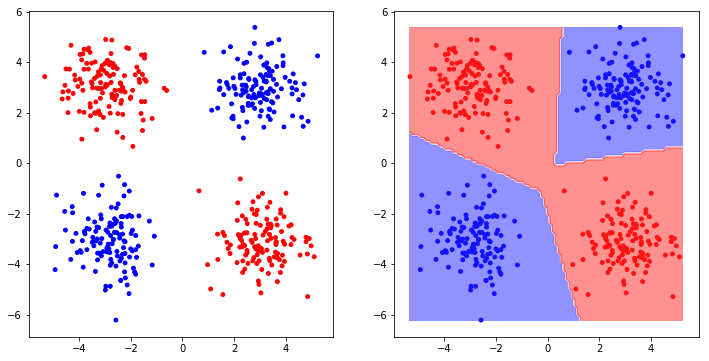

In [29]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 3, 3, 1], activations=[relu, relu, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3)

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, nn, threshold=0.5, s=15)

### Círculos

In [30]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/10000 cost: 0.68877359
epoch: 1000/10000 cost: 0.01100054
epoch: 2000/10000 cost: 0.00721160
epoch: 3000/10000 cost: 0.00568209
epoch: 4000/10000 cost: 0.00481624
epoch: 5000/10000 cost: 0.00424231
epoch: 6000/10000 cost: 0.00382853
epoch: 7000/10000 cost: 0.00351306
epoch: 8000/10000 cost: 0.00326245
epoch: 9000/10000 cost: 0.00305736
epoch: 10000/10000 cost: 0.00288551


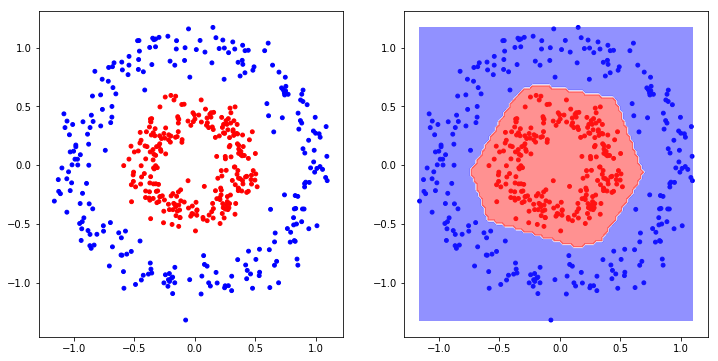

In [31]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 4, 4, 1], activations=[relu, relu, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-2)

nn.fit(x, y, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, nn, threshold=0.5, s=15)

### Espiral

In [32]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/20000 cost: 1.30775562
epoch: 2000/20000 cost: 0.04451365
epoch: 4000/20000 cost: 0.02521262
epoch: 6000/20000 cost: 0.01978162
epoch: 8000/20000 cost: 0.01733124
epoch: 10000/20000 cost: 0.01582798
epoch: 12000/20000 cost: 0.01479923
epoch: 14000/20000 cost: 0.01404336
epoch: 16000/20000 cost: 0.01345978
epoch: 18000/20000 cost: 0.01299292
epoch: 20000/20000 cost: 0.01260927


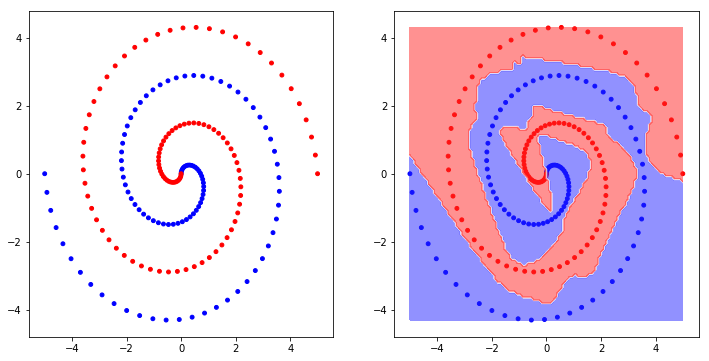

In [33]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 8, 8, 1], activations=[tanh, tanh, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-2)

nn.fit(x, y, epochs=20000, verbose=2000)

plots.plot_data_and_predictions_3d_in_2d(x, y, nn, threshold=0.5, s=15)

## Classificação Multiclasse

In [34]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder

data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [35]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


In [37]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 1, 3], activations=[relu, linear], cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

epoch:    0/10000 cost: 2.46524340
epoch: 1000/10000 cost: 0.82179282
epoch: 2000/10000 cost: 0.63412120
epoch: 3000/10000 cost: 0.42495664
epoch: 4000/10000 cost: 0.33225859
epoch: 5000/10000 cost: 0.29074551
epoch: 6000/10000 cost: 0.26251781
epoch: 7000/10000 cost: 0.24091702
epoch: 8000/10000 cost: 0.22367756
epoch: 9000/10000 cost: 0.20959328
epoch: 10000/10000 cost: 0.19788306


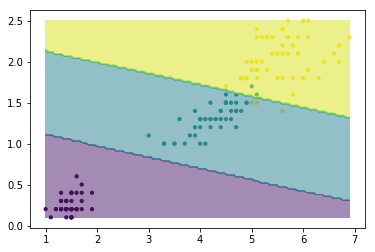

In [38]:
x1, x2 = np.meshgrid(np.linspace(x[:,0].min(), x[:,0].max(), 100), np.linspace(x[:,1].min(), x[:,1].max(), 100))
x_mesh = np.array([x1.ravel(), x2.ravel()]).T
y_mesh = np.argmax(softmax(nn.predict(x_mesh)), axis=1)

plt.figure(0)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=10)
plt.contourf(x1, x2, y_mesh.reshape(x1.shape), alpha=0.5)

# Referências

[Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

[Dataset da Regressão Quadrática](https://mathbits.com/MathBits/TISection/Statistics2/quadratic.html)

[Dataset da Regressão Logarítimica](https://mathbits.com/MathBits/TISection/Statistics2/logarithmic.htm)

__TODO__:
- regularização
- evitar overflow das funções de ativação
- métodos de inicialização de pesos e bias
- mini-batch SGD
- dropout
- early_stopping

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```